# Task

For this week tasks, please re-use the AirPassenger dataset.

## 1. Manually implement the symmetrically center CMA-12 for the AirPassenger data and compare the result when using `rolling()` method.

Let's begin our script by importing necessary libraries:

In [1]:
# Import some external libraries
import pandas as pd                # For data manipulation
import matplotlib.pyplot as plt    # For visualization
import numpy as np                 # For linear algebra

Then read the data file into a DataFrame object and use the Month column as the index of the DataFrame and plot the time seres data

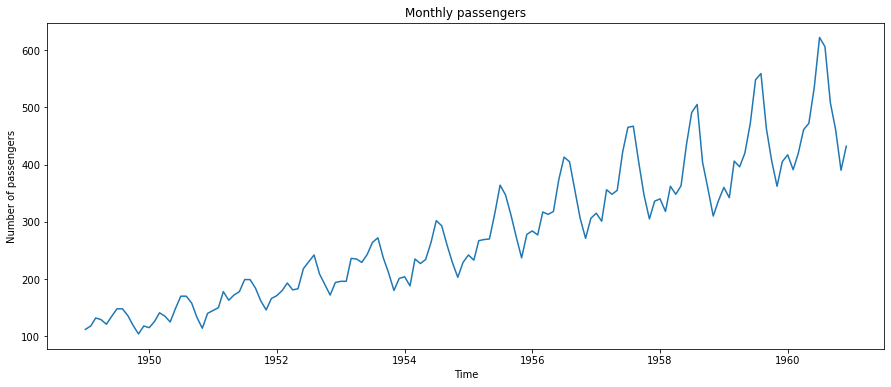

In [2]:
# Read data from a csv file
data = pd.read_csv('AirPassengers.csv')       
data['Month'] = pd.to_datetime(data['Month']) # Convert the data in the Month column to datetime
data.set_index('Month', inplace=True)         # Indexing the DataFrame by the Month column
data.head()                                   # See the first 5 rows

# Extract Passengers column
ts = data['Passengers']

# Plot number of passengers over time
plt.figure(figsize=(15,6))         
plt.plot(ts.index,ts)
plt.xlabel('Time')
plt.ylabel('Number of passengers')
plt.title('Monthly passengers')
plt.show()

Now let's implement CMA-12 manually and compare the results obtained from the `rolling()` method

In [3]:
# Define the window size k=12 and compute m=k/2
k = 12
m = int(k/2)

# Create empty lists to store smoothed values for (t+0.5) and (t-0.5)
# New smoothed values will be appended in each iteration
ts_CMA12_1 = []
ts_CMA12_2 = []

# Using a for loop to compute smoothed values at each time point
for i in np.arange(m,len(ts)-m):
    ts_CMA12_1.append(ts[i-m:i+m].mean())
    ts_CMA12_2.append(ts[i-m+1:i+m+1].mean())

# Create the smoothed series using index column of the passenger series    
ts_CMA12_manual = data['Passengers'].copy()
ts_CMA12_manual[:] = np.nan    

# Assign smoothed values
ts_CMA12_manual[m:-m] = 0.5*(np.array(ts_CMA12_1)+np.array(ts_CMA12_2))

# CMA-12 using rolling()
ts_CMA12_rolling = ts.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)

# Store smoothed values in a DataFrame
data['CMA_12_manual'] = ts_CMA12_manual
data['CMA_12_rolling'] = ts_CMA12_rolling

print(data.head(10))
print(data.tail(10))

            Passengers  CMA_12_manual  CMA_12_rolling
Month                                                
1949-01-01         112            NaN             NaN
1949-02-01         118            NaN             NaN
1949-03-01         132            NaN             NaN
1949-04-01         129            NaN             NaN
1949-05-01         121            NaN             NaN
1949-06-01         135            NaN             NaN
1949-07-01         148     126.791667      126.791667
1949-08-01         148     127.250000      127.250000
1949-09-01         136     127.958333      127.958333
1949-10-01         119     128.583333      128.583333
            Passengers  CMA_12_manual  CMA_12_rolling
Month                                                
1960-03-01         419     465.208333      465.208333
1960-04-01         461     469.333333      469.333333
1960-05-01         472     472.750000      472.750000
1960-06-01         535     475.041667      475.041667
1960-07-01         622      

## 2. Implement the MA-3 forecasting technique in Section 3 using a for loop

We will create an empty list and append new forecast values in each iteration

In [4]:
# Extract data for in-sample period (1949-1959)
ts_in = ts['1949':'1959']
T_in = len(ts_in) 

# Extract data for out-of-sample period (1960)
ts_out = ts['1960']
T_out = len(ts_out)

# Forecast using rolling() (similar to the tutorial)
ts_rolling = ts.rolling(3).mean()
ts_one_step_MA = ts_rolling[-T_out-1:-1].to_numpy()  

# Now forecast using a for loop
ts_one_step_MA_manual = []   # Create an empty list
for t in np.arange(T_out):
    Y_forecast = ts[T_in-3+t:T_in+t].mean()
    ts_one_step_MA_manual.append(Y_forecast)

# It is useful to put true and forecast for out-out-sample data in the same DataFrame
ts_forecast_df = pd.DataFrame(ts_out)
ts_forecast_df['Pred_one_step_MA3_rolling'] = ts_one_step_MA
ts_forecast_df['Pred_one_step_MA3_manual'] = np.array(ts_one_step_MA_manual)
print(ts_forecast_df)

            Passengers  Pred_one_step_MA3_rolling  Pred_one_step_MA3_manual
Month                                                                      
1960-01-01         417                 391.333333                391.333333
1960-02-01         391                 394.666667                394.666667
1960-03-01         419                 404.333333                404.333333
1960-04-01         461                 409.000000                409.000000
1960-05-01         472                 423.666667                423.666667
1960-06-01         535                 450.666667                450.666667
1960-07-01         622                 489.333333                489.333333
1960-08-01         606                 543.000000                543.000000
1960-09-01         508                 587.666667                587.666667
1960-10-01         461                 578.666667                578.666667
1960-11-01         390                 525.000000                525.000000
1960-12-01  

## 3. Compare the forecast values produced in Section 3 to the forecast values made by the naive methods in tutorial 3. Using RMSE error as the predictive measure, which model produces the most accurate forecast?

First let's replicate the forecast results using simple and seasonal naive methods from tutorial 3. For the simple naive method

In [5]:
# Define forecast horizon (one-step ahead)
h = 1   

# Create a Series to store forecast values (pre-allocation)
ts_one_step_naive1 = pd.Series(np.zeros(T_out))
ts_one_step_naive1.index = ts_out.index

# Iterate through out-of-sample time steps
for i in np.arange(T_out):
    ts_one_step_naive1[i] = ts[T_in+i-h]

For the seasonal naive method

In [6]:
# Seasonal period
M = 12

# Create a Series to store forecast values (pre-allocation)
ts_one_step_naive2 = pd.Series(np.zeros(T_out))
ts_one_step_naive2.index = ts_out.index

# Create a loop 
for i in np.arange(T_out):
    ts_one_step_naive2[i] = ts[T_in+i-M]

Then we define a simple function to compute the RMSE measure of two input arrays of the same length (this is the function we defined in tutorial 3)

In [7]:
def RMSE(y_true,y_pred):
    mse = np.sqrt(np.mean((y_true-y_pred)**2))
    return(mse)

Now we can compute RMSE measures for all methods

In [8]:
print('RMSE (Simple naive)  : {:.2f}'.format(RMSE(ts_out,ts_one_step_naive1)))
print('RMSE (Seasonal naive): {:.2f}'.format(RMSE(ts_out,ts_one_step_naive2)))
print('RMSE (MA-3)  : {:.2f}'.format(RMSE(ts_out,ts_one_step_MA)))

RMSE (Simple naive)  : 53.15
RMSE (Seasonal naive): 50.71
RMSE (MA-3)  : 78.24


For the AirPassenger data, MA-3 seems to produce less accurate forecast values, measured in RMSE, than naive methods. This result is expected as the rolling window size is 3, which is not a good valuee, e.g. $k=M=12$ could improve the result (we can try!). 